## Exercise 7: Fit MNIST with SVM and GaborSVM


**a)** The most common objective for SVM when we have slack variables (soft margin SVM) is:
$$J(\theta,\xi) = \frac{1}{2}\|\theta\|^2 + C\| \xi \|_p^p \quad (p \geq 1)$$ 

   subject to the constraints,
$$ y_i(\theta^Tx_i+\theta_0) \geq 1 - \xi_i,\quad \xi_i \geq 0,\quad \forall i = 1,\cdots,n$$
  which quantifies our intuition that $\xi_i$ must be small. 

* This makes SVM training a convex optimization problem since the objective is convex function and the constraint is a linear inequality which defines a convex set.

* Usually, p=1 (L1 Soft Margin SVM) or p=2 (L2 Soft Margin SVM). For p=2, the primal is strictly convex and thus the solution is unique.

**b)** The **support vectors** are defined as those vectors that identify the separating hyperplane of maximum margin. This means that $(\theta,\theta_0)$ can be written as a linear combination of exactly those vectors. As we saw in class for the dual perceptron, the coefficients of the linear combination are the Lagrangian multipliers. Thus, the support vectors are *exactly* those vectors that have non-zero Lagrange multipliers. From KKT conditions this means that for support vectors, the constraint is tight. The reverse is not true (degenerate cases). 

* For the interested reader Slater's conditions are satisfied for SVM optimization problem and thus, the duality gap is zero and KKT conditions are both necessary and sufficient

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.filters import gabor_kernel, gabor
import matplotlib.pyplot as plt
import cv2
import time

### c) Download MNIST, downsample and Split into train/validation set.

In [2]:
ds = fetch_openml('mnist_784')
x,y = ds.data, ds.target

In [3]:
ds = 2
def resize_dataset(dataset,ds):
    size_x = dataset.shape[1]
    resize_x = int(np.sqrt(size_x))
    dataset = dataset.reshape((-1,resize_x,resize_x))
    d_dsampled = np.zeros((dataset.shape[0],size_x//ds**2))
    for i in range(dataset.shape[0]):
        d_dsampled[i] = cv2.resize(dataset[i], (resize_x//ds,resize_x//ds)).flatten()
    return d_dsampled

x_dsampled = resize_dataset(x,ds)
x_train, x_val, y_train, y_val = train_test_split(x_dsampled,y,test_size = 0.2,random_state = 42)


Digit:  5


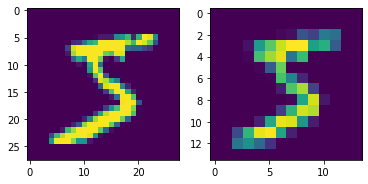

In [4]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x[0].reshape(28,28))
axarr[1].imshow(x_dsampled[0].reshape(14,14))
print("Digit: ", y[0])

### d) Create and an Fit SVM Classifier
* For reference on the problems solved by LIBSVM (SVC is a wrapper for it) see: https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf
* For sklearn.svm.SVC documentation (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
* **C** : penalty parameter of C the error term (default=1.0) (It can also be viewed as the upper limit for the Lagrange coeffcients if we form the dual problem).
* **gamma** : Kernel coefficient for 'rbf','poly','sigmoid' (default 'auto' = $\frac{1}{n_{features}}$. For 'rbf' for example, it is inversely proportional to the variance.

In [5]:
classifier = svm.SVC(C=1000, kernel='poly', gamma='auto', cache_size=2000, verbose=10)
classifier.fit(x_train,y_train)

[LibSVM]

SVC(C=1000, cache_size=2000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=10)

In [6]:
y_pred_val = classifier.predict(x_val)
print("Predicted Digits: ", y_pred_val)
print("Classifier Score: ", classifier.score(x_val, y_val))
print("Confusion Matrix: ")
print(confusion_matrix(y_pred_val,y_val))


Predicted Digits:  ['8' '4' '8' ... '2' '7' '1']
Classifier Score:  0.9759285714285715
Confusion Matrix: 
[[1325    0    5    4    3    2    2    3    4    7]
 [   0 1583    7    1    0    5    0    5    6    3]
 [   4    3 1347   11    3    3    4   12    6    2]
 [   0    7    3 1391    2    7    0    1   14   11]
 [   1    1    0    1 1269    2    4    8    3   12]
 [   1    0    1    8    0 1240    8    0    9    3]
 [   6    1    0    0    0    6 1376    0    1    0]
 [   2    2    7    5    1    0    0 1462    4   12]
 [   4    1    9    5    1    6    2    1 1305    5]
 [   0    2    1    7   16    2    0   11    5 1365]]


In [7]:
print("Support Vectors Percentage: ", classifier.n_support_.sum()/x_train.shape[0])

Support Vectors Percentage:  0.095875


**e)** The link for libsvm above gives detailed explanation of the "shrinking" parameter and when it is advised to be used. The optimization algorithm is also described. It is an implementation of the paper http://www.jmlr.org/papers/volume6/fan05a/fan05a.pdf. In brief, the **optimization algorithm** is a Sequential Minimal Optimization (SMO)-type algorithm that aims to solve the dual (quadratic) program by updating a subset of the lagrange multipliers in each iteration, so that the whole process gets decomposed into smaller subproblems and fits into the RAM. This, in general, leads to slow convergence, so the paper proposes a way of choosing which parameters should be updated by finding the violating pairs of a second-order objective. **Shrinking** is a preprocessing heuristic that aims to improve the hit rate of the kernel cache, as well, by temporarily eliminating dual variables that are unlikely to be selected in the SMO working set because they have reached their lower or upper bound. 

**f)** When we deal with binary classifiers, the usual multiclass classification extension is either **one-vs-one**, where we train $ \textit{classes} \choose 2$ binary classifiers and to classify a new point  they 'vote' on the region and the point gets classified with majority vote rule, or **one-vs-all** where we train *classes* classifiers and *classes-1* of them group against the remaining one. A point is classified in the region that attains the largest value of the decision function. 

* The interested readers are encouraged to read about *DAGSVM* method.

* Although the libsvm document above, mentions only the one-versus-one case, the default now is one-versus-all for SVC(). It is also recommended when training time is a major concern, although it is not consistent. 

### g) Grid Search

In [8]:
params = [{'C':[0.1,10,100,1000,10000], 'gamma':[1e-9,1e-7,1e-6,1e-5,1e-4,5*1e-3,1], 'kernel':['rbf','poly']}]
classifier = GridSearchCV(svm.SVC(cache_size=2000), params, cv=5, scoring='accuracy', verbose=10,n_jobs=4)
classifier.fit(x_train[:5000],y_train[:5000])

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  4.4min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=2000, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [0.1, 10, 100, 1000, 10000],
                          'gamma': [1e-09, 1e-07, 1e-06, 1e-05, 0.0001, 0.005,
                                    1],
                          'kernel': ['rbf', 'poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=10)

### Best SVM Classifier: Validation Accuracy >96%

In [9]:
print('Best score for training data:', classifier.best_score_,"\n") 
print('Best C:',classifier.best_estimator_.C,"\n") 
print('Best Kernel:',classifier.best_estimator_.kernel,"\n")
print('Best Gamma:',classifier.best_estimator_.gamma,"\n")

classifier = classifier.best_estimator_
print('Best score for validation data:',classifier.score(x_val, y_val))
y_pred_val = classifier.predict(x_val)
print("Confusion Matrix: ")
print(confusion_matrix(y_pred_val,y_val))

Best score for training data: 0.9564 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 1e-06 

Best score for validation data: 0.9607857142857142
Confusion Matrix: 
[[1326    0    6    3    7    2    5    2    2    5]
 [   1 1578    5    9    2    9    2    9    5    4]
 [   2    4 1333   21    3    6    2   14   11    3]
 [   1    5    3 1349    0   23    0    1   25   11]
 [   1    2    8    2 1234    4    4    9    9   30]
 [   3    1    4   23    1 1211    7    1    9    3]
 [   5    0    3    2    9    6 1369    0    6    0]
 [   1    2    8    5    5    0    1 1437    4   22]
 [   1    3    7   11    2    7    5    3 1279    7]
 [   2    5    3    8   32    5    1   27    7 1335]]


### h) Downsample Dataset, Keep it balanced.

In [10]:
def balancedsample_dataset(x,y,keep_elems):
    all_class_dat = []
    all_class_lab = []
    
    for cl in np.unique(y):
        per_class_mat = x[(y == cl)]
        num_elems = per_class_mat.shape[0]
        np.random.shuffle(per_class_mat)
        all_class_dat.append(per_class_mat[:min(keep_elems,num_elems)])
        all_class_lab.append([int(cl)]*min(keep_elems,num_elems))    
    
    all_class_dat = np.concatenate(all_class_dat)
    all_class_lab = np.concatenate(all_class_lab)
    
    all_class_dat = np.hstack((all_class_dat, all_class_lab.reshape(-1,1)))
    np.random.shuffle(all_class_dat)
    all_class_lab = all_class_dat[:,-1]
    all_class_dat = all_class_dat[:,:-1]
    return all_class_dat,all_class_lab.astype(np.int)


nx_train,ny_train = balancedsample_dataset(x_train,y_train,500)
nx_val, ny_val = balancedsample_dataset(x_val,y_val,500)

small_nx_train, small_ny_train = balancedsample_dataset(x_train,y_train,50)
small_nx_val, small_ny_val = balancedsample_dataset(x_val,y_val,50)


### f) Gabor SVM

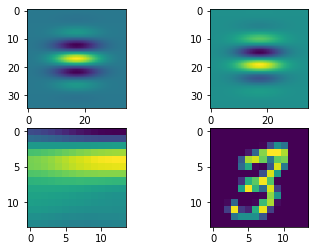

In [17]:
freq,theta,bandwidth = 0.1, np.pi/2, 1
gk = gabor_kernel(frequency=freq,theta=theta,bandwidth=bandwidth)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(gk.real)
axarr[0,1].imshow(gk.imag)

#plt.figure(1); plt.clf(); plt.imshow(gk.real)
#plt.figure(2); plt.clf(); plt.imshow(gk.imag)

# convolve the input image with the kernel and get co-efficients
# we will use only the real part and throw away the imaginary
# part of the co-efficients
image = x_train[40].reshape((14,14))
coeff_real, _ = gabor(image, frequency=freq, theta=theta,bandwidth=bandwidth)
end = time.time()
axarr[1,0].imshow(coeff_real)
axarr[1,1].imshow(image)

#plt.figure(1); plt.clf(); plt.imshow(coeff_real)
#plt.figure(2); plt.clf(); plt.imshow(image)


#### Parameters for the filterbank

In [37]:
theta = np.array([np.pi/4,np.pi/2,3*np.pi/4, np.pi])
frequency = np.array([0.05,0.25])
bandwidth = np.array([0.1,1])
#theta = np.arange(0,np.pi,np.pi/4)
#frequency = np.arange(0.05,0.5,0.15)
#bandwidth = np.arange(0.3,1,0.3)
n_filters = len(frequency)*len(theta)*len(bandwidth)
print(n_filters)

16


#### Plot to check diversity

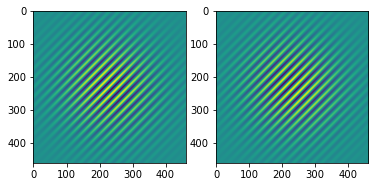

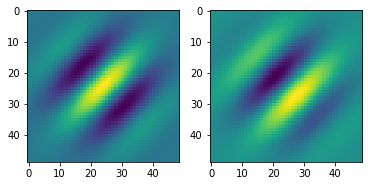

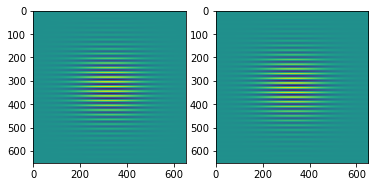

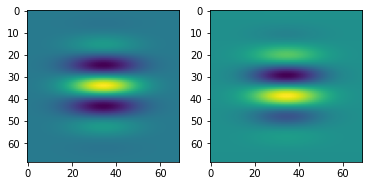

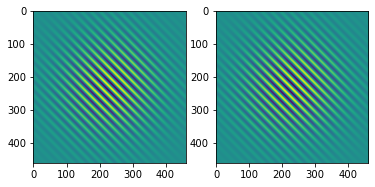

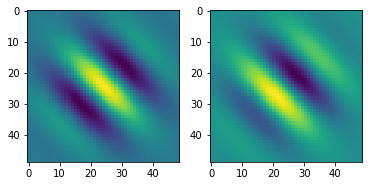

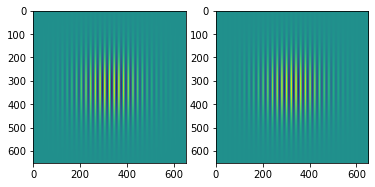

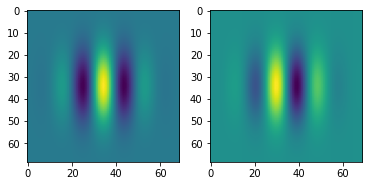

In [38]:
l=0
for i in frequency:
    for j in theta:
        for k in bandwidth:
            gk = gabor_kernel(frequency=i, theta=j, bandwidth=k)
            if l < 8:
                f, axarr = plt.subplots(1,2)
                axarr[0].imshow(gk.real)
                axarr[1].imshow(gk.imag)
                time.sleep(0.1)
            l+=1

#### Next part is computationally intensive.

In [39]:
from tqdm import tnrange,tqdm_notebook
def gfilter_dataset(x,freq,theta,band):
    n_filters = len(freq)*len(theta)*len(band)
    x_gabor = np.zeros((x.shape[0],n_filters*x.shape[1]))
    for img in tqdm_notebook(range(x.shape[0])):
        turn = 1
        for f in frequency:
            for t in theta:
                for b in bandwidth:
                    x_gabor[img,(turn-1)*x.shape[1]:turn*x.shape[1]]= gabor(x[img].reshape((14,14)),frequency=f,theta=t,bandwidth=b)[0].flatten() #append
                    turn += 1
    return x_gabor


In [40]:
#x_gabor_train = gfilter_dataset(nx_train,frequency,theta,bandwidth)
#x_gabor_val = gfilter_dataset(nx_val,frequency,theta,bandwidth)

x_small_gabor_train = gfilter_dataset(small_nx_train,frequency,theta,bandwidth)
x_small_gabor_val = gfilter_dataset(small_nx_val,frequency,theta,bandwidth)


/home/evangelos/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [41]:
np.save('x_gabor_train',x_small_gabor_train)
np.save('x_gabor_val', x_small_gabor_val)

In [47]:
x_small_gabor_train = np.load('x_gabor_train.npy')
x_small_gabor_val = np.load('x_gabor_val.npy')

print(x_small_gabor_train.shape)

(500, 3136)


# Standardize and PCA features

In [44]:
scaler = StandardScaler()
scaler.fit(x_small_gabor_train)
x_small_gabor_train = scaler.transform(x_small_gabor_train)
x_small_gabor_val = scaler.transform(x_small_gabor_val)

#x_gabor_val[np.isnan(x_gabor_val)] = 0 

In [45]:
explained_variance = 0.98
pca = PCA(explained_variance)
pca.fit(x_small_gabor_train)
x_small_gabor_train_pca = pca.transform(x_small_gabor_train)
x_small_gabor_val_pca = pca.transform(x_small_gabor_val)
x_small_gabor_val_pca.shape

(500, 35)

#### The following SVM occured from a GridSearch.
#### Best SVM classifier: Validation Accuracy > 93%

In [48]:
classifier = svm.SVC(C=1.0, kernel='poly', gamma='auto', cache_size=1000, verbose=True)
classifier.fit(x_small_gabor_train,small_ny_train)
y_pred = classifier.predict(x_small_gabor_val)
print(y_pred)
print("Classifier Accuracy:", classifier.score(x_small_gabor_val, small_ny_val))

[LibSVM][7 9 5 0 1 6 6 5 1 5 3 1 2 2 9 7 9 9 9 8 9 8 1 8 5 9 0 8 8 5 8 2 4 1 9 2 6
 9 3 2 9 5 1 0 5 2 2 2 2 9 7 1 7 6 7 9 3 3 8 4 3 2 5 1 1 0 8 9 1 1 7 9 6 6
 9 7 4 5 3 9 1 4 6 7 2 7 9 9 7 9 0 4 5 7 8 3 9 4 4 4 4 4 3 3 5 6 3 6 3 0 3
 5 2 6 9 4 5 5 0 0 0 7 6 4 6 9 2 4 1 2 5 2 0 4 4 5 0 3 7 9 9 2 4 8 9 7 0 5
 6 6 2 1 9 8 5 1 2 2 2 6 3 1 3 4 0 5 9 6 3 3 8 5 4 2 6 2 2 2 4 1 2 2 8 4 8
 1 7 3 1 3 0 3 6 5 4 2 8 0 2 8 3 5 7 0 5 5 4 3 2 7 7 6 9 6 5 9 3 5 4 0 1 8
 6 5 0 3 5 2 8 1 6 6 8 9 3 2 6 0 4 6 6 8 0 5 2 1 9 4 5 1 7 9 0 6 9 6 4 6 5
 0 7 9 0 6 4 7 7 2 6 8 8 6 6 1 0 0 3 8 3 7 0 1 8 4 6 2 3 2 3 0 4 0 3 9 4 9
 5 5 0 7 1 4 2 9 9 7 8 0 5 7 8 6 8 5 1 7 0 2 1 9 8 9 3 3 5 6 9 0 2 2 7 1 0
 7 7 8 2 0 1 0 1 1 4 4 2 6 6 8 8 6 7 1 0 4 6 8 8 8 5 0 7 9 1 3 2 7 2 6 7 4
 8 9 7 4 3 5 4 3 6 5 5 4 3 8 1 5 5 6 0 3 9 7 0 9 8 7 8 9 8 9 0 2 8 4 1 7 4
 4 1 6 8 3 1 5 2 2 7 1 0 6 6 7 2 1 0 2 0 0 2 2 6 3 0 4 4 2 2 0 0 2 5 5 0 3
 7 3 5 0 1 6 7 1 6 4 4 1 8 8 1 9 4 1 8 6 3 2 4 7 8 1 0 8 4 8 3 0 3 7 7 1 5
 7 7 3 9 2 8 4 4 

(5000, 7056)